In [1]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy, AUC
from sklearn.model_selection import train_test_split

# !pip install tensorflow-addons==0.9.1
# import tensorflow_addons 
# from tensorflow_addons.metrics import F1Score, CohenKappacore, CohenKappa
# from tensorflow_addons.metrics import F1Score, CohenKappa

In [2]:
# Add an additional column, mapping to the type
Image_info_df = pd.read_csv('../Data/Gaussian_Retina_Data/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


Image_info_df['binary_type'] =  Image_info_df['diagnosis'].map(diagnosis_dict_binary.get)
Image_info_df['type'] = Image_info_df['diagnosis'].map(diagnosis_dict.get)
Image_info_df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


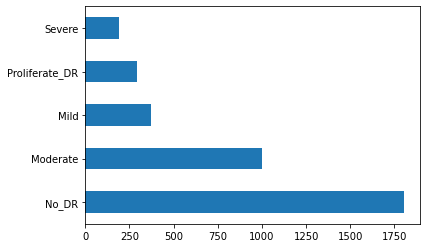

In [3]:
Image_info_df['type'].value_counts().plot(kind='barh')

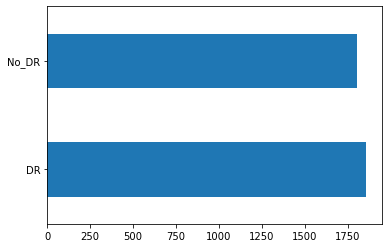

In [4]:
Image_info_df['binary_type'].value_counts().plot(kind='barh')

In [5]:
# Split into stratified train, val, and test sets
train, test = train_test_split(Image_info_df, test_size = 0.20)

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')

No_DR             1444
Moderate           799
Mild               278
Proliferate_DR     251
Severe             157
Name: type, dtype: int64 

No_DR             361
Moderate          200
Mild               92
Proliferate_DR     44
Severe             36
Name: type, dtype: int64 



In [6]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)


In [7]:
# Copy images to respective working directory
src_dir = '../Data/Gaussian_Retina_Data/gaussian_filtered_images/gaussian_filtered_images/'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [8]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2929 images belonging to 5 classes.
Found 733 images belonging to 5 classes.


# 8 Layer CNN Model

In [9]:
# Building the model
# LOOK AT NUMBER OF NODES
# LOOK AT STACKING AND UNSTACKING as MULTIPLES OF 2

model = models.Sequential([
    layers.Conv2D(16, (3, 3), padding="same", activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(256, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3, 3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(1, 1)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(8, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(5, activation = 'softmax')

])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        9

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=100,
                    validation_data=test_batches)

Epoch 1/100
92/92 [==============================] - 134s 1s/step - loss: 0.6896 - acc: 0.3520 - val_loss: 0.6915 - val_acc: 0.0477
Epoch 2/100
92/92 [==============================] - 131s 1s/step - loss: 0.5899 - acc: 0.4681 - val_loss: 0.6935 - val_acc: 0.0491
Epoch 3/100
92/92 [==============================] - 129s 1s/step - loss: 0.5453 - acc: 0.5183 - val_loss: 0.7016 - val_acc: 0.0450
Epoch 4/100
92/92 [==============================] - 138s 2s/step - loss: 0.5251 - acc: 0.5166 - val_loss: 0.7218 - val_acc: 0.0491
Epoch 5/100
92/92 [==============================] - 138s 2s/step - loss: 0.5102 - acc: 0.5449 - val_loss: 0.7223 - val_acc: 0.0723
Epoch 6/100
92/92 [==============================] - 127s 1s/step - loss: 0.4933 - acc: 0.5562 - val_loss: 0.6044 - val_acc: 0.3233
Epoch 7/100
92/92 [==============================] - 120s 1s/step - loss: 0.4837 - acc: 0.5647 - val_loss: 0.5204 - val_acc: 0.4679
Epoch 8/100
92/92 [==============================] - 124s 1s/step - loss: 0.

In [11]:
acc = model.evaluate(test_batches, verbose=1)
print("Accuracy: ", acc[1])

23/23 [==============================] - 8s 352ms/step - loss: 0.3274 - acc: 0.6521
Accuracy:  0.6521145701408386


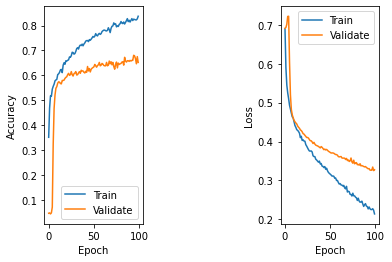

In [30]:
plt.subplot(1,3,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='lower right')

plt.subplot(1,3,3)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper right')


In [13]:
#  Predict the label of the test_images
pred = model.predict(test_batches)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_batches.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')

The first 10 predictions: ['Moderate', 'Proliferate_DR', 'Proliferate_DR', 'Proliferate_DR', 'Proliferate_DR', 'Proliferate_DR', 'Proliferate_DR', 'No_DR', 'Severe', 'Proliferate_DR']


In [14]:
# Save the model
model.save("Retinopathy_model_trained_100.h5")

In [15]:
# Load the model
from tensorflow.keras.models import load_model
retinopathy_model = load_model("Retinopathy_model_trained_100.h5")

In [18]:
model_loss, model_accuracy = retinopathy_model.evaluate(
    test_batches, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

23/23 - 8s - loss: 0.3274 - acc: 0.6521
Normal Neural Network - Loss: 0.3273581564426422, Accuracy: 0.6521145701408386


In [20]:
test_batches

In [21]:
labels

{0: 'Mild', 1: 'Moderate', 2: 'No_DR', 3: 'Proliferate_DR', 4: 'Severe'}

In [56]:
type(history.history)
history.history

{'loss': [0.689613401889801,
  0.589885413646698,
  0.5453456044197083,
  0.5250523090362549,
  0.5101675987243652,
  0.4933442771434784,
  0.4836743474006653,
  0.47317519783973694,
  0.4638115465641022,
  0.46053552627563477,
  0.4510166347026825,
  0.4412117898464203,
  0.4365213215351105,
  0.43048736453056335,
  0.4286656081676483,
  0.4256402254104614,
  0.42136913537979126,
  0.40997421741485596,
  0.4135645925998688,
  0.4027225971221924,
  0.4044218957424164,
  0.40116414427757263,
  0.40085268020629883,
  0.3919580280780792,
  0.38805699348449707,
  0.38344961404800415,
  0.37901443243026733,
  0.3756190538406372,
  0.3754619359970093,
  0.37580859661102295,
  0.37319445610046387,
  0.3634006083011627,
  0.36138829588890076,
  0.361207515001297,
  0.3545309901237488,
  0.3524259626865387,
  0.3496493399143219,
  0.34685736894607544,
  0.3497190773487091,
  0.34249091148376465,
  0.3434838652610779,
  0.3366793990135193,
  0.3359401822090149,
  0.3329612612724304,
  0.33564525

In [46]:
df=pd.DataFrame.from_dict(history.history, orient="index")
df.to_csv("history_data.csv")

In [50]:
reload_history=pd.read_csv("history_data.csv", index_col=0)
reload_history

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
loss,0.689613,0.589885,0.545346,0.525052,0.510168,0.493344,0.483674,0.473175,0.463812,0.460536,...,0.233939,0.232535,0.226714,0.231708,0.226965,0.225021,0.224962,0.227179,0.223336,0.213801
acc,0.351997,0.468078,0.518266,0.516559,0.544896,0.556163,0.564698,0.578354,0.581769,0.584158,...,0.813930,0.820758,0.827586,0.819734,0.825538,0.824172,0.822806,0.822465,0.826903,0.837146
val_loss,0.691474,0.693454,0.701565,0.721845,0.722287,0.604446,0.520377,0.482589,0.468944,0.460966,...,0.333368,0.331529,0.329874,0.330352,0.326515,0.326194,0.326312,0.334355,0.325164,0.327358
val_acc,0.047749,0.049113,0.045020,0.049113,0.072306,0.323329,0.467940,0.521146,0.548431,0.555252,...,0.660300,0.657572,0.660300,0.660300,0.680764,0.678035,0.667121,0.646658,0.675307,0.652115


In [53]:
new_history = reload_history.to_dict("split")

new_history = dict(zip(new_history["index"], new_history["data"]))

In [54]:
new_history

{'loss': [0.689613401889801,
  0.589885413646698,
  0.5453456044197083,
  0.5250523090362549,
  0.5101675987243652,
  0.4933442771434784,
  0.4836743474006653,
  0.473175197839737,
  0.4638115465641022,
  0.4605355262756348,
  0.4510166347026825,
  0.4412117898464203,
  0.4365213215351105,
  0.43048736453056335,
  0.4286656081676483,
  0.4256402254104614,
  0.4213691353797913,
  0.409974217414856,
  0.4135645925998688,
  0.4027225971221924,
  0.4044218957424164,
  0.40116414427757263,
  0.4008526802062988,
  0.3919580280780792,
  0.38805699348449707,
  0.38344961404800415,
  0.3790144324302673,
  0.3756190538406372,
  0.3754619359970093,
  0.37580859661102295,
  0.3731944561004639,
  0.3634006083011627,
  0.3613882958889008,
  0.36120751500129705,
  0.3545309901237488,
  0.3524259626865387,
  0.3496493399143219,
  0.34685736894607544,
  0.3497190773487091,
  0.34249091148376465,
  0.3434838652610779,
  0.3366793990135193,
  0.3359401822090149,
  0.3329612612724304,
  0.3356452584266662

In [57]:
pred

['Moderate',
 'Proliferate_DR',
 'Proliferate_DR',
 'Proliferate_DR',
 'Proliferate_DR',
 'Proliferate_DR',
 'Proliferate_DR',
 'No_DR',
 'Severe',
 'Proliferate_DR',
 'Proliferate_DR',
 'Proliferate_DR',
 'Severe',
 'Proliferate_DR',
 'No_DR',
 'No_DR',
 'Proliferate_DR',
 'Severe',
 'Proliferate_DR',
 'Proliferate_DR',
 'Proliferate_DR',
 'Proliferate_DR',
 'No_DR',
 'Moderate',
 'No_DR',
 'No_DR',
 'Proliferate_DR',
 'No_DR',
 'No_DR',
 'No_DR',
 'No_DR',
 'Proliferate_DR',
 'Moderate',
 'Proliferate_DR',
 'Moderate',
 'No_DR',
 'Proliferate_DR',
 'Proliferate_DR',
 'Proliferate_DR',
 'No_DR',
 'Proliferate_DR',
 'Proliferate_DR',
 'Proliferate_DR',
 'Proliferate_DR',
 'Proliferate_DR',
 'Moderate',
 'Proliferate_DR',
 'Proliferate_DR',
 'Proliferate_DR',
 'Moderate',
 'Proliferate_DR',
 'Moderate',
 'Proliferate_DR',
 'Proliferate_DR',
 'Proliferate_DR',
 'Moderate',
 'Proliferate_DR',
 'Moderate',
 'Moderate',
 'Moderate',
 'Proliferate_DR',
 'Moderate',
 'Moderate',
 'No_DR',
 'P

In [58]:
type(pred)

list

In [61]:
import csv
with open("pred.csv", 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(pred)

In [62]:
type(test_batches)

tensorflow.python.keras.preprocessing.image.DirectoryIterator

In [63]:
train_path = 'train'
test_path = 'test'

train_x_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
test_x_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2929 images belonging to 5 classes.
Found 733 images belonging to 5 classes.
